# Final Project

Ok, so today we'll be working with the transactions, product, and hh_demographic tables in the project_data folder.

* First, read in the transactions data.

* Read in the only columns `household_key`, `BASKET_ID`, `DAY`, `PRODUCT_ID`, `QUANTITY`, and `SALES_VALUE`.

* Convert `DAY`, `QUANTITY`, and `PRODUCT_ID` to the smallest appropriate integer types.


In [19]:
import pandas as pd
import numpy as np

In [20]:
path = "project_data/project_transactions.csv"

# specify columns to keep
cols = ["household_key", "BASKET_ID", "DAY", "PRODUCT_ID", "QUANTITY", "SALES_VALUE"]

# specify datatypes to convert
dtypes = {"DAY": "Int16", "QUANTITY": "Int32", "PRODUCT_ID": "Int32"}

transactions = pd.read_csv(path,
                           dtype=dtypes,
                           usecols=cols
                          )

In [3]:
transactions.describe().round()

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE
count,2146311.0,2.146311e+06,2146311.0,2146311.0,2146311.0,2146311.0
mean,1056.0,3.404897e+10,390.0,-861.0,101.0,3.0
std,605.0,4.723748e+09,190.0,3831949.0,1152.0,4.0
min,1.0,2.698490e+10,1.0,25671.0,0.0,0.0
25%,548.0,3.040798e+10,229.0,917231.0,1.0,1.0
50%,1042.0,3.281176e+10,392.0,1027960.0,1.0,2.0
75%,1581.0,4.012804e+10,555.0,1132771.0,1.0,3.0
max,2099.0,4.230536e+10,711.0,18316298.0,89638.0,840.0


In [4]:
transactions.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2146311 entries, 0 to 2146310
Data columns (total 6 columns):
 #   Column         Dtype  
---  ------         -----  
 0   household_key  int64  
 1   BASKET_ID      int64  
 2   DAY            Int16  
 3   PRODUCT_ID     Int32  
 4   QUANTITY       Int32  
 5   SALES_VALUE    float64
dtypes: Int16(1), Int32(2), float64(1), int64(2)
memory usage: 75.7 MB


In [21]:
# Use the following snippet to create a Date Column then drop. Then drop the `DAY` column.

transactions = (transactions
                .assign(date = 
                        (pd.to_datetime("2016", format='%Y') 
                        + pd.to_timedelta(transactions["DAY"].sub(1).astype(str) + " days"))
                       )
                .drop(["DAY"], axis=1)
               )

In [22]:
transactions.columns = transactions.columns.str.lower()

In [23]:
transactions.head()

,household_key,basket_id,product_id,quantity,sales_value,date
0,1364,26984896261,842930,1,2.19,2016-01-01
1,1364,26984896261,897044,1,2.99,2016-01-01
2,1364,26984896261,920955,1,3.09,2016-01-01
3,1364,26984896261,937406,1,2.50,2016-01-01
4,1364,26984896261,981760,1,0.60,2016-01-01


## TIME BASED ANALYSIS

* Plot the sum of sales by month. Are sales growing over time?
* Next, plot the same series after filtering down to dates April 2016 and October 2017.
* Then, plot the sum of sales 2016 vs the 2017 sales.
* Then, plot total sales by day of week.

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 100)
plt.style.use("seaborn-whitegrid")

In [25]:
transactions.dtypes

household_key             int64
basket_id                 int64
product_id                Int32
quantity                  Int32
sales_value             float64
date             datetime64[ns]
dtype: object

In [26]:
transactions['order_month'] = transactions['date'].dt.month

In [30]:
plot_data = transactions.groupby("order_month")["sales_value"].sum()\
                                                                .reset_index()

In [31]:
plot_data

,order_month,sales_value
0,1,366859.17
1,2,395373.42
2,3,511033.05
3,4,576588.37
4,5,627148.82
5,6,593745.41
6,7,609341.54
7,8,645621.51
8,9,619539.15
9,10,656027.65


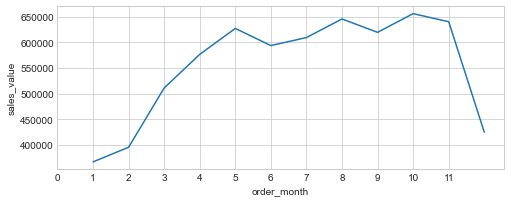

In [49]:
# Set a date index, graby the sales column, and calculate a monthly sum using resampling.
# Then build the default line plot

fig, ax = plt.subplots(figsize = (8,3))

sns.lineplot(
    x = 'order_month',
    y = 'sales_value',
    data = plot_data,
    ax = ax
)

ax.set_xticks(np.arange(0,12,1), minor = False)

plt.show()


<AxesSubplot:xlabel='date'>

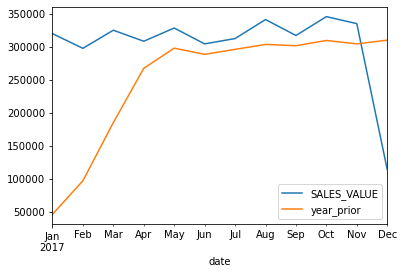

In [9]:
# After resampling monthly sales, create a year_prior column with assign
# This column is our monthly sales shifted forward a year (12 rows/months)

(transactions
 .set_index("date")
 .loc[:, ["SALES_VALUE"]]
 .resample("M")
 .sum()
 .assign(year_prior = lambda x: x["SALES_VALUE"].shift(12))
 .loc["2017"]
 .plot()
)

<AxesSubplot:xlabel='date'>

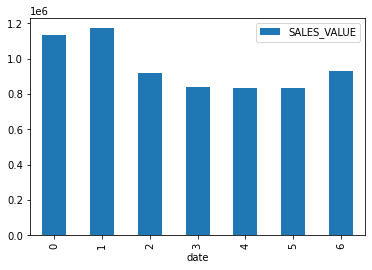

In [10]:
# Group transactions by dayofweek, then calculate sum and plot a bar chart
(transactions
 .groupby(transactions["date"].dt.dayofweek)
 .agg({"SALES_VALUE": "sum"})
 .plot.bar()
)

# DEMOGRAPHICS

* Read in the `hh_demographic.csv` file, but only the columns `AGE_DESC`, `INCOME_DESC`, `household_key`, and `HH_COMP_DESC`. Convert the appropriate columns to the category dtype.


* Then group the transactions table by household_id, and calculate the sum of SALES VALUE by household.


* Once you've done that, join the demographics DataFrame to the transactions table. Since we're interested in analyzing the demographic data we have, make sure not to include rows from transactions that don't match.


* Plot the sum of sales by age_desc and income_desc.


* Then, create a pivot table of the mean household sales by `AGE_DESC` and `HH_COMP_DESC`. Which of our demographics have the highest average sales?


In [11]:
# Specify columns to include 
dem_cols = ["AGE_DESC", "INCOME_DESC", "household_key", "HH_COMP_DESC"]

# Convert the object columns here to category dtype
dem_dtypes = {"AGE_DESC": "category", "INCOME_DESC": "category", "HH_COMP_DESC":"category"}

demographics = pd.read_csv('../project_data/hh_demographic.csv',
                          usecols=dem_cols,
                          dtype=dem_dtypes
                          )

In [12]:
demographics.head()

,AGE_DESC,INCOME_DESC,HH_COMP_DESC,household_key
0,65+,35-49K,2 Adults No Kids,1
1,45-54,50-74K,2 Adults No Kids,7
2,25-34,25-34K,2 Adults Kids,8
3,25-34,75-99K,2 Adults Kids,13
4,45-54,50-74K,Single Female,16


In [13]:
demographics.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   AGE_DESC       801 non-null    category
 1   INCOME_DESC    801 non-null    category
 2   HH_COMP_DESC   801 non-null    category
 3   household_key  801 non-null    int64   
dtypes: category(3), int64(1)
memory usage: 10.9 KB


In [14]:
# Create total sales by household dataframe

household_sales = (transactions
                   .groupby("household_key")
                   .agg({"SALES_VALUE": "sum"})
                  )

household_sales

,SALES_VALUE
household_key,
1,4330.16
2,1954.34
3,2653.21
4,1200.11
5,779.06
...,...
2095,3790.49
2096,1301.65
2097,8823.83


In [15]:
# Join household sales and demographics table on household_key (inner since we're interested in both sets)

household_sales_demo = (household_sales.merge(demographics, 
                             how="inner",
                             left_on='household_key',
                             right_on="household_key",
                             )
                       )

In [16]:
household_sales_demo.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 668 entries, 0 to 667
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   household_key  668 non-null    int64   
 1   SALES_VALUE    668 non-null    float64 
 2   AGE_DESC       668 non-null    category
 3   INCOME_DESC    668 non-null    category
 4   HH_COMP_DESC   668 non-null    category
dtypes: category(3), float64(1), int64(1)
memory usage: 19.8 KB


<AxesSubplot:xlabel='AGE_DESC'>

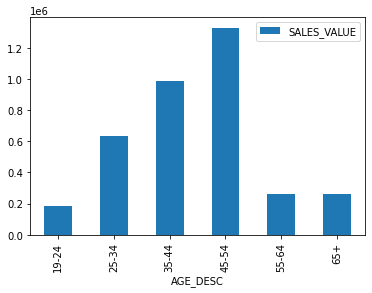

In [17]:
# Calculate sum of sales by age group

(household_sales_demo
.groupby(["AGE_DESC"])
.agg({"SALES_VALUE": "sum"})
.plot.bar()
)

<AxesSubplot:xlabel='INCOME_DESC'>

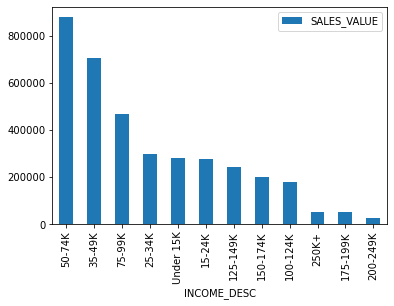

In [18]:
# Calculate sum of sales by income, ordered by magnitude

(household_sales_demo
 .groupby(["INCOME_DESC"])
 .agg({"SALES_VALUE": "sum"})
 .sort_values("SALES_VALUE", ascending=False)
 .plot.bar())

In [19]:
# Calculate mean household spend by Age Description and HH Composition
# Format with a heatmap across all cells

(household_sales_demo.pivot_table(index="AGE_DESC", 
                 columns="HH_COMP_DESC",
                 values="SALES_VALUE",
                 aggfunc="mean",
                 margins=True)
 .style.background_gradient(cmap="RdYlGn", axis=None)
)

HH_COMP_DESC,1 Adult Kids,2 Adults Kids,2 Adults No Kids,Single Female,Single Male,Unknown,All
AGE_DESC,,,,,,,
19-24,7268.796667,5428.945000,4020.800000,4576.095556,3216.835000,4911.275000,4692.077692
25-34,5512.196875,5753.973514,5638.515833,4807.440588,4909.522381,7356.270000,5435.517521
35-44,6297.737778,6691.772264,6260.412444,6015.192069,4844.192000,4227.691818,6090.556728
45-54,6632.569167,6610.484490,5839.527027,4549.365405,4636.637083,4843.995682,5534.879958
55-64,3064.870000,4695.655000,5752.413684,4816.148462,3922.546250,7973.750000,5168.924200
65+,4040.810000,5536.866667,4614.108571,4059.699412,3871.556000,2879.290000,4340.936500
All,6032.802143,6280.069103,5599.857756,4895.928361,4544.646750,4936.127778,5468.398743


In [20]:
# delete dfs we won't use anymore

del [household_sales_demo, household_sales]

# PRODUCT DEMOGRAPHICS

* Read in the product csv file.

* Only read in product_id and department from product (consider converting columns).

* Join the product DataFrame to transactions and demographics tables, performing an inner join when joining both tables.

* Finally, pivot the fully joined dataframe by AGE_DESC and DEPARTMENT, calculating the sum of sales. Which category does our youngest demographic perform well in?



In [21]:
# specify columns to use
product_cols = ["PRODUCT_ID", "DEPARTMENT"]

# specify datatypes for each column
product_dtypes = {"PRODUCT_ID": "Int32", "DEPARTMENT": "category"}

product = pd.read_csv('../project_data/product.csv',
                     usecols=product_cols,
                     dtype=product_dtypes
                     )

In [22]:
product.dtypes

PRODUCT_ID       Int32
DEPARTMENT    category
dtype: object

In [23]:
# Join all three tables together with an inner join
# Join product on product_id (only shared column)
trans_demo_dept = (transactions
                  .merge(demographics, 
                         how="inner",
                         left_on='household_key',
                         right_on="household_key",)
                  .merge(product,
                         how="inner",
                         left_on="PRODUCT_ID",
                         right_on="PRODUCT_ID")
             
             )

In [24]:
# much smaller than our original, uncoverted transactions df!
trans_demo_dept.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1161575 entries, 0 to 1161574
Data columns (total 10 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   household_key  1161575 non-null  int64         
 1   BASKET_ID      1161575 non-null  int64         
 2   PRODUCT_ID     1161575 non-null  Int32         
 3   QUANTITY       1161575 non-null  Int32         
 4   SALES_VALUE    1161575 non-null  float64       
 5   date           1161575 non-null  datetime64[ns]
 6   AGE_DESC       1161575 non-null  category      
 7   INCOME_DESC    1161575 non-null  category      
 8   HH_COMP_DESC   1161575 non-null  category      
 9   DEPARTMENT     1161575 non-null  category      
dtypes: Int32(2), category(4), datetime64[ns](1), float64(1), int64(2)
memory usage: 59.8 MB


In [25]:
# Where does our youngest demographic rank near the top in sales?

(trans_demo_dept.pivot_table(index="DEPARTMENT",
                            columns="AGE_DESC",
                            values="SALES_VALUE",
                            aggfunc="sum")
 .style.background_gradient(cmap="RdYlGn", axis=1))

AGE_DESC,19-24,25-34,35-44,45-54,55-64,65+
DEPARTMENT,,,,,,
,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AUTOMOTIVE,11.640000,21.250000,72.580000,55.920000,0.000000,16.370000
CHARITABLE CONT,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CHEF SHOPPE,81.300000,134.160000,348.530000,418.240000,80.860000,149.240000
CNTRL/STORE SUP,2.000000,0.000000,1.000000,9.950000,2.000000,0.100000
COSMETICS,698.630000,2273.030000,4362.020000,5187.570000,986.260000,600.900000
COUP/STR & MFG,7.490000,48.420000,121.200000,154.550000,40.680000,20.490000
DAIRY DELI,3.800000,3.850000,7.390000,16.750000,3.140000,1.940000
DELI,4043.300000,18181.940000,34577.290000,44334.220000,9850.540000,10462.330000


# EXPORT

Finally, export your pivot table to an excel file. Make sure to provide a sheet name.

In [26]:
# Call to_excel on pivot table above - note the formatting gets passed to excel too!

(trans_demo_dept.pivot_table(index="DEPARTMENT",
                            columns="AGE_DESC",
                            values="SALES_VALUE",
                            aggfunc="sum")
 .style.background_gradient(cmap="RdYlGn", axis=1)
 .to_excel("demographic_category_sales.xlsx", sheet_name="sales_pivot")
)